# Predicting Subscription Status to a Minecraft Related Newsletter Using Player Characteristics

#### Group Members: Karuna Johnson, Laison Tao, Tomomi Koch, Xiao Chen

## Introduction

A research group in computer science at UBC has collected data about how people play video games. They set up a Minecraft server to log data on how people participate in the game. Minecraft is a sandbox game that allows players to use materials to build structures and equipment to stay safe from the elements. To run their project successfully, the research group needs to focus their recruitment efforts strategically to make sure they have enough resources to handle all the players. We wanted to determine what types of players would be most likely to subscribe to a game-related newsletter, which prompted us to the question: **Can player age, number of sessions, and experience level predict whether or not they are subscribed to a game-related newsletter?** To answer this, we used the 2 data sets the research group provided: `players` and `sessions`. 

The `players` data set contains 7 columns:
- Experience level (beginner, amateur, regular, veteran, and pro)
- Subscription status (TRUE/FALSE)
- Players hashed email (individual encoded email)
- Played hours (hours)
- Player name
- Player gender
- Player age (years)
  
The `sessions` data set contains 5 columns:
- Players hashed email
- Start time (date and time PST)
- End time (date and time PST) 
- Original start time (milliseconds since epoch)
- Original end time (milliseconds since epoch)



## Methods & Results

### Overview of Our Methodology

1. Reading & Wrangling: We imported two datasets (`players.csv` and `sessions.csv`), merged them by hashedEmail, and tidied the resulting data frame. We computed the number of sessions per player as a key engagement metric.
2. Exploratory Data Analysis (EDA): We explored the distributions of player age, experience level, and number of sessions and visualized how subscription rates varied across player types. This helped form early hypotheses about which features might be informative.
3. Feature Preparation: We normalized the numeric predictors (age, number of sessions, and encoded experience level) to prepare them for modeling with KNN. Players with missing values were excluded.
4. Train/Test Split: The cleaned and normalized dataset was randomly split into training (75%) and testing (25%) sets. This allowed us to build and evaluate our model on separate data.
5. K-Nearest Neighbors Classification: We trained a K-Nearest Neighbors model using k = 15, selected after initial tuning with 5 fold cross-validation. We predicted the test set and evaluated the model using a confusion matrix and accuracy metrics.

<h3>Loading relevant libraries</h3>

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(ggplot2)
library(forcats)
library(lubridate)
library(cowplot)
options(repr.matrix.max.rows = 5) # limits output of dataframes to 5 rows

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Reading and Wrangling our data

- We read the two datasets provided by the research group (`players` and `sessions`) via raw files uploaded to Github
- Using the `select()` function, we selected the relevant columns (`experience`, `subscribe`, `age` and `hashedEmail`) required for our research question. These columns were chosen based on visualizations made in our individual project planning reports.
- The `experience` and `subscribe` columns in the players datasets were of categorical and logical variables, respectively. They were mutated into factor types using `as.factor()` to ensure correct behavior in modeling and plotting functions.
- Since there were 2 missing values in the `age` column in the `players` dataset, the `na.omit()` function was used to remove those observations to prevent errors during model training. 

In [2]:
players <- read_csv("https://raw.githubusercontent.com/karunaj28/DSCI100-Group-Project/refs/heads/main/data/players.csv") |>
    select(experience, subscribe, hashedEmail, Age) |>
    mutate(experience = as_factor(experience)) |>
    mutate(subscribe = as_factor(subscribe)) |>
    na.omit()
players

sessions <- read_csv("https://raw.githubusercontent.com/karunaj28/DSCI100-Group-Project/refs/heads/main/data/sessions.csv") |>
    select(hashedEmail)
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,Age
<fct>,<fct>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17
⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,17


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail
<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686


### Combining the two datasets

- Since the `sessions` dataset had a row for each session, we grouped them by the `hashedEmail` column to compute the number of sessions per player. 
- Using the `summarize()` function, we created a new column called `number_of_sessions` which stores the count of rows (sessions) for each player.
- The two datasets (`players` and `sessions_n`) were combined using `left_join`. The join was performed using the `hashedEmail` column as the key, ensuring each player retained their age, subscription status and experience information while gaining their session count.
- We then used `filter(!is.na(number_of_sessions))` to remove any players who had no recorded sessions in the sessions dataset to ensure that our analysis focused only on players with actual gameplay activity.
- The resulting dataset, `players_sessions`, contains each player’s age, experience level, subscription status, and number of sessions, all of which are used in our predictive modeling.

In [3]:
sessions_n <- sessions |>
  group_by(hashedEmail) |>
  summarize(number_of_sessions = n(), .groups = "drop")

column_names <- c("experience", "subscribe", "hashed_email", "age", "number_of_sessions")
players_sessions <- players |>
  left_join(sessions_n, by = "hashedEmail") |>
  filter(!is.na(number_of_sessions)) 
colnames(players_sessions) <- column_names
players_sessions

experience,subscribe,hashed_email,age,number_of_sessions
<fct>,<fct>,<chr>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17,1
⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,17,1
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,17,6


### Summarizing the Training Data

- After wrangling the data, we have a total of 123 usable observations.
- We used `set.seed()` to have reproducible results.
- We randomly split 75% of the data is split into the training set and the remaining 25% into the test set using `initial_split` to ensure that we have an adequate amount of observations for training and evaluating the prediction accuracy of our model.

In [4]:
set.seed(1234)
ps_split <- initial_split(players_sessions, prop = 0.75, strata = subscribe)
ps_train <- training(ps_split)
ps_test <- testing(ps_split)

- The data was summarized into Table 1.1, which tells us the number of observations in each class (not subscribed (FALSE) or subscribed (TRUE)).
- It is observed that there are more cases of TRUE as compared to FALSE in the training set

In [5]:
n_per_class <- ps_train |>
    group_by(subscribe) |>
    summarize(n = n())

#### Table 1.1: Total Subscribed (TRUE)/ Not Subscribed (FALSE) cases in the training set
| subscribe | n  |
|-----------|----|
| FALSE     | 24 |
| TRUE      | 68 |

- The summary statistics (mean, median, standard deviation, maximum and minimum values) were computed for the numerical variables being used in our analysis using summarize. The results were reported in Table 1.2

In [6]:
avg_pred_vals <- ps_train |>
    summarize(total_players = n(),
    mean_age = mean(age, na.rm = TRUE),
    median_age = median(age, na.rm = TRUE),
    sd_age = sd(age, na.rm = TRUE),
    min_age = min(age, na.rm = TRUE),
    max_age = max(age, na.rm = TRUE),
    mean_sessions = mean(number_of_sessions, na.rm = TRUE),
    median_sessions = median(number_of_sessions, na.rm = TRUE),
    sd_sessions = sd(number_of_sessions, na.rm = TRUE),
    min_sessions = min(number_of_sessions, na.rm = TRUE),
    max_sessions = max(number_of_sessions, na.rm = TRUE))

#### Table 1.2: Summary statistics for numerical predictors
| Total Players | Mean Age | Median Age | SD Age | Min Age | Max Age | Mean Sessions | Median Sessions | SD Sessions | Min Sessions | Max Sessions |
|---------------|----------|------------|--------|---------|---------|----------------|------------------|--------------|----------------|----------------|
| 92            | 20.32609    | 18         | 6.76466  | 8       | 50      | 12.67391         | 1                | 36.23947        | 1              | 219            |

## Visualizations of the predictors in the training data

- The bar charts below depict the distributions of the 3 chosen predictor variables.
- First, we created bins of the `Age` variable with 5-year intervals using `cut()` and labeled the resulting groups (e.g., "0-5", "6-10", ..., "50+"). We then calculated the proportion of subscribed players (`subscription_rate`) within each age bin. This data was visualized in a horizontal bar chart (Figure 1.1).
- A similar approach was applied to the `number_of_sessions` variable. Players were grouped into session count bins (e.g., "0-10", "11-20", ..., "150+"). The proportion of subscribers within each session range was calculated and plotted (Figure 1.2)
- Since the `experience` variable was already classified by player type, we calculated the mean subscription rate for each player level and created a bar chart (Figure 1.3).
- All three bar plots were styled using the same colorblind friendly palette ("Paired") and formatting, then arranged vertically using `plot_grid()` to allow easier comparison of subscription trends across the three predictors.

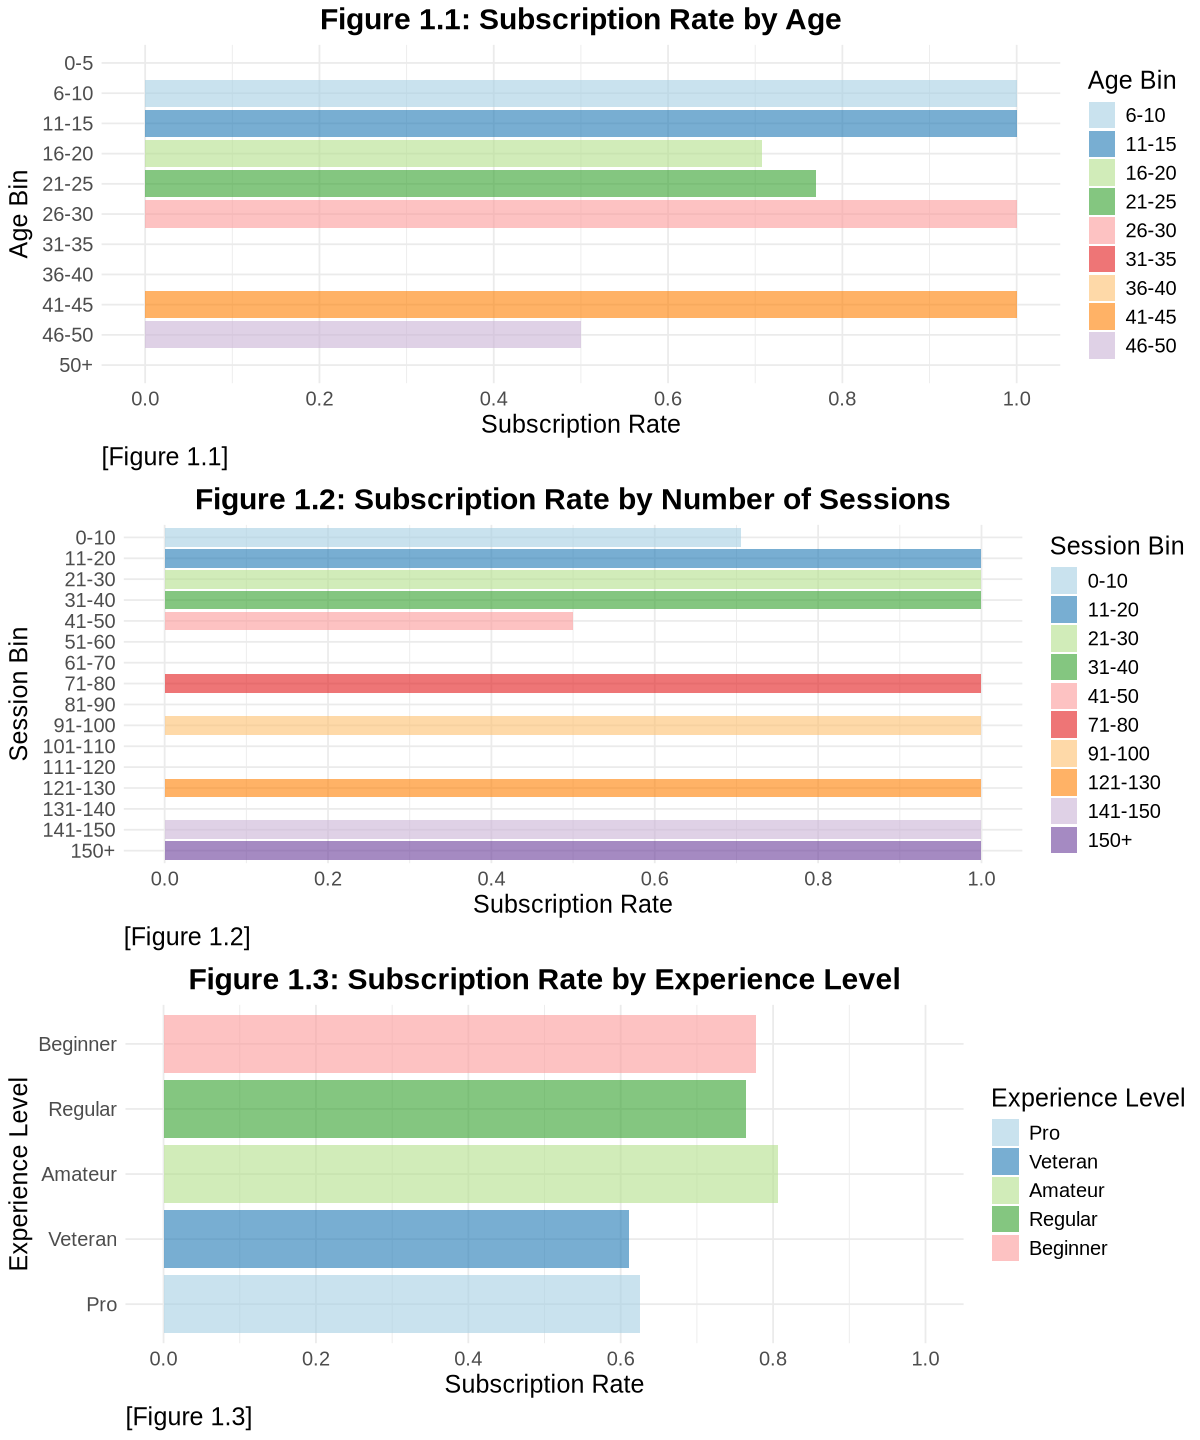

In [7]:
ps_train_age <- ps_train |>
  mutate(age_bin = cut(age, 
                       breaks = c(seq(0, 50, by = 5), Inf), 
                       include.lowest = TRUE, 
                       labels = c("0-5", "6-10", "11-15", "16-20", "21-25", 
                                  "26-30", "31-35", "36-40", "41-45", "46-50", "50+")))

subscription_rate_by_age <- ps_train_age |>
  group_by(age_bin) |>
  summarise(subscription_rate = mean(subscribe == "TRUE"), .groups = "drop")

barplot_age <- ggplot(subscription_rate_by_age, aes(x = subscription_rate, y = age_bin, fill = age_bin)) +
  geom_bar(stat = "identity", alpha = 0.6) +
  scale_fill_brewer(palette = "Paired", name = "Age Bin") +
  labs(title = "Figure 1.1: Subscription Rate by Age",
       x = "Subscription Rate",
       y = "Age Bin",
       caption = "[Figure 1.1]") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "right", 
        plot.caption = element_text(hjust = 0, size = 15), 
        text = element_text(size = 15)) +
  scale_y_discrete(limits = rev(levels(subscription_rate_by_age$age_bin))) +
  scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2))



ps_train_sessions <- ps_train |>
  mutate(session_bin = cut(number_of_sessions, 
                           breaks = c(seq(0, 150, by = 10), Inf), 
                           include.lowest = TRUE, 
                           labels = c("0-10", "11-20", "21-30", "31-40", "41-50", "51-60", 
                                      "61-70", "71-80", "81-90", "91-100", "101-110", 
                                      "111-120", "121-130", "131-140", "141-150", "150+")))

subscription_rate_by_sessions <- ps_train_sessions |>
  group_by(session_bin) |>
  summarise(subscription_rate = mean(subscribe == "TRUE"), .groups = "drop")

barplot_sessions <- ggplot(subscription_rate_by_sessions, aes(x = subscription_rate, y = session_bin, fill = session_bin)) +
  geom_bar(stat = "identity", alpha = 0.6) +
  scale_fill_brewer(palette = "Paired", name = "Session Bin") +
  labs(title = "Figure 1.2: Subscription Rate by Number of Sessions",
       x = "Subscription Rate",
       y = "Session Bin",
       caption = "[Figure 1.2]") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "right", 
        plot.caption = element_text(hjust = 0, size = 15), 
        text = element_text(size = 15)) +
  scale_y_discrete(limits = rev(levels(subscription_rate_by_sessions$session_bin))) +
  scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2))

subscription_rates <- ps_train |>
  group_by(experience) |>
  summarise(subscription_rate = mean(subscribe == "TRUE"), .groups = "drop")

barplot_experience <- ggplot(subscription_rates, aes(x = subscription_rate, y = experience, fill = experience)) +
  geom_bar(stat = "identity", alpha = 0.6) +
  scale_fill_brewer(palette = "Paired", name = "Experience Level") +
  labs(title = "Figure 1.3: Subscription Rate by Experience Level",
       x = "Subscription Rate",
       y = "Experience Level",
       caption = "[Figure 1.3]") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "right",
        plot.caption = element_text(hjust = 0, size = 15), 
        text = element_text(size = 15)) +
  scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2))

options(repr.plot.width = 10, repr.plot.height = 12)
all_plots <- plot_grid(
    barplot_age,
    barplot_sessions,
    barplot_experience,
    ncol = 1)
all_plots

#### **Visualization Analysis**
**Figure 1.1: Subscription Rate by Age**
- **Age Distribution of Subscription Rates:** The subscription rate varies notably across different age bins. The graph shows that individuals in the 6-15, 26–30, and 41-45 age groups have the highest subscription rates at 100%. Meanwhile, the 16-25 age groups (Gen Z generation) exhibit moderate subscription rates of 70-80%, possibly reflecting lower interest or access. The eldest group from 46-50 exhibits even less subscription rates at around 50%, possibly reflecting lower interest as well.


**Figure 1.2: Subscription Rate by Number of Sessions**
- **Session Distribution of Subscription Rates:** This figure indicates a positive correlation between the number of sessions and subscription rate. Users in higher session bins, above 70 sessions  exhibit consistently 100% subscription rate. In contrast, the 41–50 session bin stands out with a notably lower subscription rate at 50%, suggesting a potential anomaly or user drop-off point. The 0–10 bins also show lower rates, likely representing new users still attempting or new sign-up users.

**Figure 1.3: Subscription Rate by Experience Level**
- **Experience Level Distribution of Subscription Rates:**  Among different experience levels, Amateur have the highest subscription rate above 80%, followed closely by Beginner and Regular users. This is somewhat counterintuitive, as people might expect experienced users to be more committed. Veterans and Pros have moderate to lower rates around 60%, which might reflect lower interest in the content or issues in the game, which experienced players would more likely notice.

## Tuning our K-NN Classifier and Selecting our K-value

To select the optimal K-value for our KNN model, we:
- Construct a recipe with our selected predictors: `experience`, `age`, and `number_of_sessions`
- Create a specification for our model, using `tune()` as n to tune our model and chose the most optimal K-value
- perform a cross verification with 5 folds
- Then, using our recipe and specifications, we construct a workflow.
- Using `tune_grid()`, we apply our cross verification on our model, before collecting the results using `collect_metrics`

In [8]:
set.seed(10)
ps_recipe <- recipe(subscribe ~ experience + age + number_of_sessions, data = ps_train) |> 
    step_scale(number_of_sessions, age) |> 
    step_center(number_of_sessions, age)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification")

ps_vfold <- vfold_cv(ps_train, v = 5, strata = subscribe)

gridvals <- tibble(neighbors = seq(1, 21))

ps_results <- workflow() |> 
    add_recipe(ps_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = ps_vfold, grid = gridvals) |> 
    collect_metrics() |> 
    filter(.metric == "accuracy")

Now that we have the metrics, its time to compare them and select a k value from them.
- We create a visualization to compare the different K-values, and determine the most stable K value from the plot.

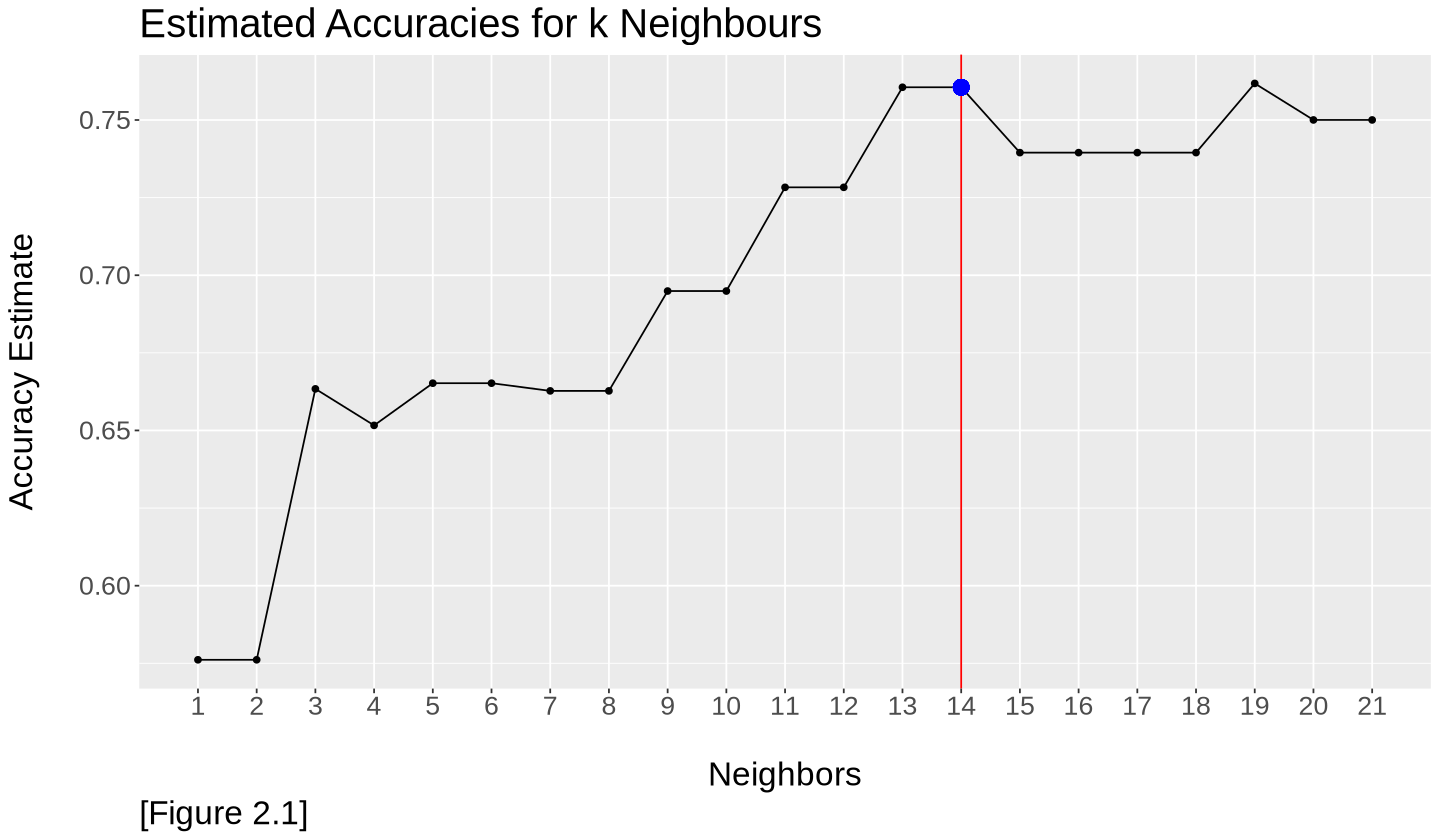

In [9]:
options(repr.plot.width = 12, repr.plot.height = 7)
selected_K = 14
ky <- ps_results |> filter(neighbors == selected_K) |> select(mean) |> pull()


cross_val_plot <- ps_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = selected_K, colour = "red") +
    geom_point(aes(x=selected_K, y= ky), size = 4, colour = "blue") +
    labs(x = "\nNeighbors",
         y = "Accuracy Estimate\n",
         title = "Estimated Accuracies for k Neighbours",
         caption = "[Figure 2.1]") +
    scale_x_continuous(limits = c(1, 21), breaks = seq(1, 21), minor_breaks = seq(1, 21, 1)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))

options(warn = -1)
cross_val_plot
options(warn = 0)

From Figure 2.1, it can be seen that a K-value of 14 offers the most accurate and stable model. It has a high relativity in comparison to the other points, only drops off in accuracy on one side, compared to k=19 which drops off on both. As such, we will choose **k = 14** to use for our model

#### Constructing the K-NN classification model
Now that we have the optimal K value, its time to build our model and test it on our testing set

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


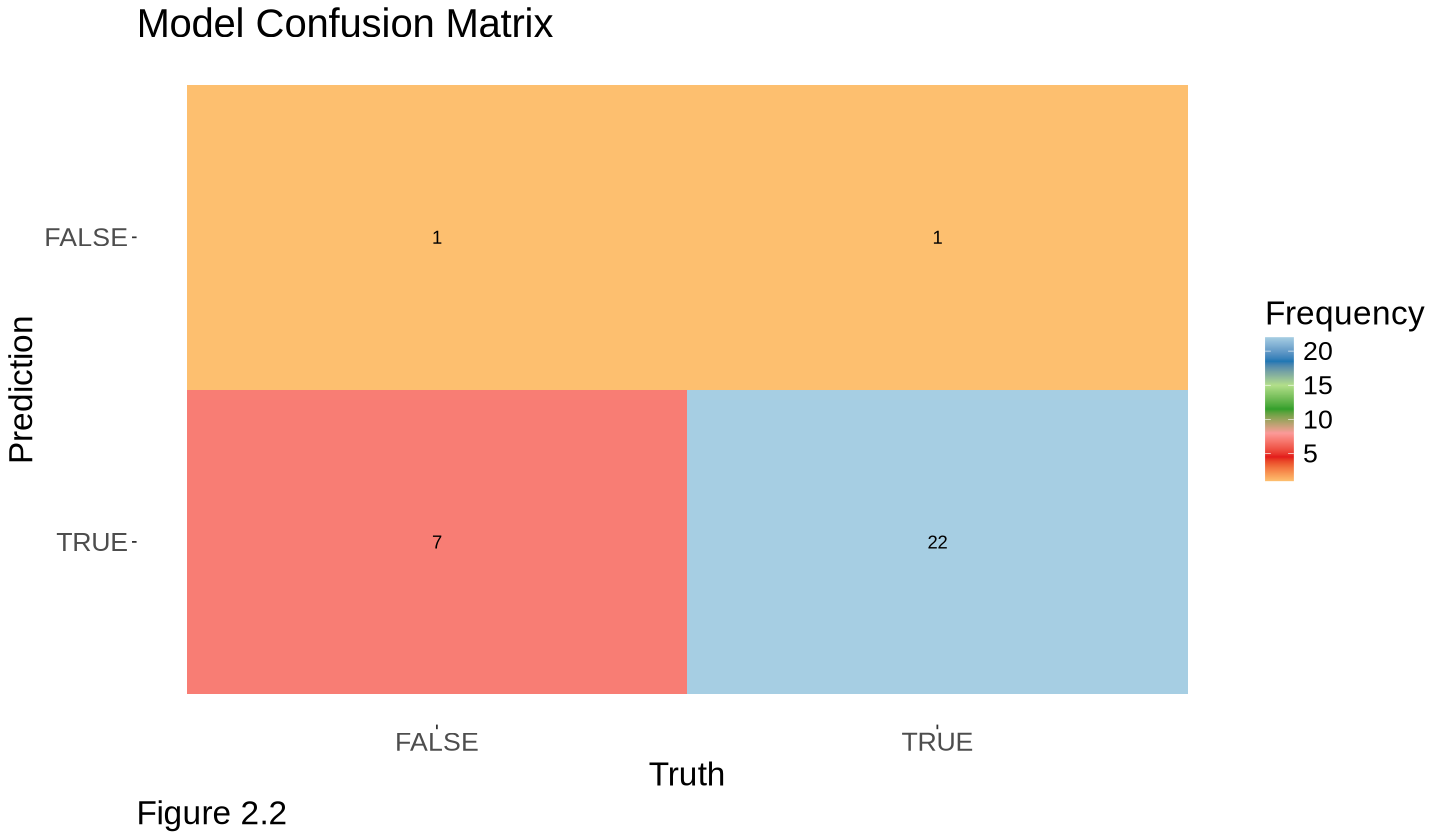

In [10]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = selected_K) |>
    set_engine("kknn") |>
    set_mode("classification")

ps_fit <- workflow() |>
  add_recipe(ps_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = ps_train)

ps_predictions <- predict(ps_fit, ps_test) |> 
    bind_cols(ps_test)

ps_acc <- ps_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

ps_cm <- ps_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

autoplot(ps_cm, type = "heatmap") +
    scale_fill_distiller(palette = "Paired", name = "Frequency") + 
    labs(title = "Model Confusion Matrix",
        caption = "Figure 2.2") +
    theme(legend.position = "right", text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))

#### Table 2.1: Model Accuracy on Testing Data

In [11]:
Table2.1 <- ps_acc 
colnames(Table2.1) <- c("Metric", "Estimate")
Table2.1

Metric,Estimate
<chr>,<dbl>
accuracy,0.7419355


Observations from Figure 2.2:
- Our model successfuly predicted a subscription 22 times, and the lack of a subscription 1 time on our testing set.
- It can be seen that our model is more susceptible to the type I error, with 7 false positives. 
- Our model tends to predict that a player will subscribe, with it classifying 29 of the players as subscribed and only 2 as not subscribed. This contributes to our high Type I error. However, it should be noted that this data set is not very diverse, with a large majority of players being subscribed (nearly 3/4ths of the populus) which may be the cause of this.

From Table 2.1, it can be extracted that our model had a 74% accuracy on our testing set.

## Discussion

We used a K-Nearest Neighbors (KNN) classification model with three predictor variables. We chose our predictors by utilizing our individual planning reports and concluded that age, number of sessions, and experience level would be the most likely to provide us with insight into a player's likelihood of subscribing to a game-related newsletter. The model achieved an accuracy of approximately 74% on the test set. This is a reasonably strong performance for a K-nearest neighbors (KNN) model using only three predictors. The confusion matrix (Figure 3) revealed that the model was able to correctly identify 23 subscribed players but failed to identify 7 of the 8 non-subscribed players, misclassifying them as subscribers. This suggests a high bias toward the majority class and indicates that the model struggles to distinguish non-subscribers. It's possible that using additional features, such as session duration or timing, could improve the model’s ability to differentiate between the two groups.

One potential limitation of our research is that the data consisted of many players who had no sessions and little to no playing time, making it difficult to analyze the data. This resulted in us not being able to use playing time as a predictor, which could have affected our results. Another limitation was that when splitting the data set into training and testing data, there was not an even split of subscribed players and not subscribed players, which could have skewed our data. We tried different proportion values, but each gave the same results, indicating that the overall data set had a higher number of subscribed players vs unsubscribed players. These limitations made it difficult to analyze player behavior. 

Overall, our model shows the relation between the number of sessions,  experience level, player age, and the importance of considering these factors when designing recruitment strategies or allocating resources on the Minecraft research server. Our findings can help the research team at UBC understand their player base and can help them to allocate resources more efficiently, for example, by targeting recruitment efforts toward players more likely to engage with the project. 

Some future questions our project could lead to include:
- Can our model be used with players in other Minecraft research servers or gaming communities?
- How might we incorporate other in-game behavioral metrics like session duration, multiplayer activities, or play style?
- How do different player demographics (e.g., age, experience level) affect long-term engagement with the game?